In [2]:
import numpy as np
from gensim.models import Word2Vec
#from gensim.models.word2vec import Text2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

model = Word2Vec.load('word2vec.model')

def get_sentence_vector(sentence, model, num_words=100):
    words = sentence.split()
    vector = np.zeros(100)  
    nwords = 0
    for word in words:
        if word in model.wv:
            vector += model.wv[word]
            nwords += 1
    if nwords:
        vector /= nwords  
    return vector


def file_to_vectors(file_path, model):
    with open(file_path, 'r', encoding='utf8') as file:
        sentences = file.readlines()
    return np.array([get_sentence_vector(sentence, model) for sentence in sentences])

vectorized_file1 = file_to_vectors('datasets//new_noxin.txt', model)
vectorized_file2 = file_to_vectors('datasets//new_yes.txt', model)

X = np.vstack((vectorized_file1, vectorized_file2))

y = np.array([0] * len(vectorized_file1) + [1] * len(vectorized_file2))


In [3]:

# 训练集80%测试集20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

predictions = rf_model.predict(X_test)
print(classification_report(y_test, predictions))


from joblib import dump
dump(rf_model, 'random_forest_model.joblib')

              precision    recall  f1-score   support

           0       0.91      0.83      0.87       215
           1       0.83      0.91      0.87       194

    accuracy                           0.87       409
   macro avg       0.87      0.87      0.87       409
weighted avg       0.87      0.87      0.87       409



['random_forest_model.joblib']

auc: 0.9455166626708223


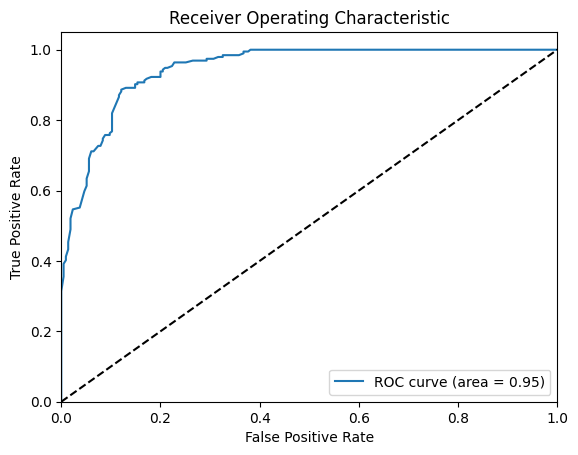

In [8]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
#ROC
y_prob = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print("auc:",roc_auc)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#调优
#from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
#from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
import joblib
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score


X, y = make_classification(n_samples=1000, n_features=20, n_informative=2, n_redundant=10, random_state=42)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}

cv = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=cv, scoring='accuracy',
                            n_jobs=-1, verbose=2, pre_dispatch='2*n_jobs',error_score='raise')

grid_search.fit(X_train, y_train)

# 输出最佳参数
print("Best parameters found: ", grid_search.best_params_)

best_rf1 = grid_search.best_estimator_

test_predictions = best_rf1.predict(X_test)
print(classification_report(y_test, test_predictions))


joblib.dump(best_rf1, 'best_rf1.pkl')

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
Best parameters found:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       111
           1       0.91      0.92      0.92        89

    accuracy                           0.93       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.93      0.93      0.93       200



['best_rf1.pkl']

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       111
           1       0.91      0.92      0.92        89

    accuracy                           0.93       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.93      0.93      0.93       200

auc: 0.9613321186354894


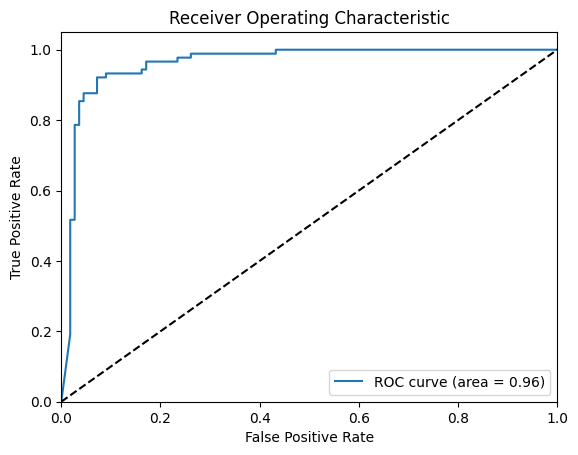

In [ ]:
predictions = best_rf1.predict(X_test)
print(classification_report(y_test, predictions))

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = best_rf1.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print("auc:",roc_auc)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [25]:
#参数比较


import joblib
from sklearn.ensemble import RandomForestClassifier

model_path = 'best_rf1.pkl'  
rf_model = joblib.load(model_path)


parameters = rf_model.get_params()
print("rf1 Model Parameters:")
for param, value in parameters.items():
    print(f"{param}: {value}")

import joblib
from sklearn.ensemble import RandomForestClassifier

model_path = 'random_forest_model.joblib'  
rf_model = joblib.load(model_path)


parameters = rf_model.get_params()
print("rf Model Parameters:")
for param, value in parameters.items():
    print(f"{param}: {value}")


rf1 Model Parameters:
bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: 10
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 5
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False
rf Model Parameters:
bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False
